In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch.optim as optim
from model.Unet_decoder import UNet1D
from model.Unet_decoder import UNet1DWithAttention
from model.Unet_decoder import CrossAttention
from torch import nn

In [29]:
import torch.nn.functional as F
from model.Unet_decoder import  SelfAttention
inputdim = 8
conditiondim = 4
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda()
model_attention = UNet1DWithAttention(inputdim, conditiondim).cuda()
model_attention.eval()
output_attention = model_attention(y, x)
output_attention.shape

torch.Size([1000, 8])

In [1]:
from model.Unet_decoder import UNet1DWithAttentionLSTM
import torch    
inputdim = 8
conditiondim = 4
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda()
model_attention = UNet1DWithAttentionLSTM(inputdim, conditiondim).cuda()
model_attention.eval()
output_attention = model_attention(y, x)
output_attention.shape

torch.Size([1000, 8])

In [3]:
class CrossAttention(nn.Module):
    def __init__(self, input_dim_q, input_dim_kv, hidden_size=32, num_heads=4):
        super(CrossAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.scale = np.sqrt(self.head_dim)

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(input_dim_q, hidden_size)  # Query projection
        self.k_proj = nn.Linear(input_dim_kv, hidden_size)  # Key projection
        self.v_proj = nn.Linear(input_dim_kv, hidden_size)  # Value projection
        self.out_proj = nn.Linear(hidden_size, input_dim_q)  # Output projection

    def forward(self, query, key_value):
        """
        Args:
            query: Tensor of shape [batch_size, seq_len_q, input_dim_q]
            key_value: Tensor of shape [batch_size, seq_len_kv, input_dim_kv]
        Returns:
            output: Tensor of shape [batch_size, seq_len_q, input_dim_q]
        """
        batch_size, seq_len_q, _ = query.shape
        seq_len_kv = key_value.shape[1]

        # Linear projections
        q = self.q_proj(query).view(batch_size, seq_len_q, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        k = self.k_proj(key_value).view(batch_size, seq_len_kv, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.v_proj(key_value).view(batch_size, seq_len_kv, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Attention scores: [batch_size, num_heads, seq_len_q, seq_len_kv]
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        # Attention weights: [batch_size, num_heads, seq_len_q, seq_len_kv]
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Attention output: [batch_size, num_heads, seq_len_q, head_dim]
        attention_output = torch.matmul(attention_weights, v)

        # Combine heads and project back to input_dim_q
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len_q, -1)
        output = self.out_proj(attention_output)

        return output

In [4]:
x = torch.randn(1000,8)
y = torch.randn(1000,4)
y = y.unsqueeze(1)
x = x.unsqueeze(1)
x.shape
cr = CrossAttention(8, 4)
cr.eval()
print(x.shape)
print(y.shape)
output = cr(x,y)
output.shape
output = output.squeeze(1)
output.shape

torch.Size([1000, 1, 8])
torch.Size([1000, 1, 4])


torch.Size([1000, 8])

In [96]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # 每个头的维度
        
        # 可训练的投影矩阵
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性投影：计算 Q, K, V
        Q = self.q_proj(query)  # [batch_size, seq_len, embed_dim]
        K = self.k_proj(key)    # [batch_size, seq_len, embed_dim]
        V = self.v_proj(value)  # [batch_size, seq_len, embed_dim]
        
        # 分头：变形为 [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 计算注意力分数：scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)  # [batch_size, num_heads, seq_len, seq_len]
        
        # 注意力加权
        attended = torch.matmul(attention_weights, V)  # [batch_size, num_heads, seq_len, head_dim]
        
        # 拼接多头的结果
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        
        # 输出投影
        output = self.out_proj(attended)  # [batch_size, seq_len, embed_dim]
        return output

In [101]:

class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim,enc_num, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.embed_dim = embed_dim
        # 多头自注意力
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # Encoder-Decoder Attention
        self.encoder_decoder_attention = CrossAttention(embed_dim,enc_num)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        # Self-Attention
        _x = x
        x = self.self_attention(query=x, key=x, value=x, mask=self_mask)

        x = self.dropout(x)
        x = self.norm1(x + _x)
        _x = x

    
        x = self.encoder_decoder_attention(query=x, key_value=enc_output)
        x = self.dropout(x)
        x = self.norm2(x + _x)

        # Feed-Forward Network
        _x = x
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.norm3(x + _x)

        x = x.view(x.shape[0], -1)
        linear_layer = nn.Linear(x.shape[1], self.embed_dim).cuda()  # 或 .to('cuda')
        x = linear_layer(x)

        return x

In [13]:
from model.transformer_block import MultiHeadAttention, CrossAttention
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim,enc_num, num_heads, ff_dim, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.embed_dim = embed_dim
        # 多头自注意力
        self.self_attention = MultiHeadAttention(embed_dim, num_heads)
        
        # Encoder-Decoder Attention
        self.encoder_decoder_attention = CrossAttention(embed_dim,enc_num)
        
        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        
        # 层归一化
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        x = x.unsqueeze(1)
        enc_output = enc_output.unsqueeze(1)
    
        _x = x
        x = self.self_attention(query=x, key=x, value=x, mask=self_mask)

        x = self.dropout(x)
        x = self.norm1(x + _x)
        _x = x

    
        x = self.encoder_decoder_attention(query=x, key_value=enc_output)
        x = self.dropout(x)
        x = self.norm2(x + _x)

        # Feed-Forward Network
        _x = x
        x = self.ffn(x)
        x = self.dropout(x)
        x = self.norm3(x + _x)

        x = x.view(x.shape[0], -1)
        linear_layer = nn.Linear(x.shape[1], self.embed_dim).cuda()  # 或 .to('cuda')
        x = linear_layer(x)

        return x

In [21]:
x = torch.randn(1000,8)
x.unsqueeze(0).shape

torch.Size([1, 1000, 8])

In [72]:

inputdim =3
conditiondim = 4
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda() 
decoder = TransformerDecoderLayer(inputdim,conditiondim, 1, 2).cuda()
print(decoder(y, x).shape)

torch.Size([1000, 3])


In [70]:

inputdim =3
conditiondim = 4
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda() 
decoder = TransformerDecoderLayer_pre(inputdim,conditiondim, 1, 2).cuda()
print(decoder(y, x).shape)

torch.Size([1000, 3])


In [76]:
from model.transformer_block import TransformerBlock

In [4]:
from model.transformer_block import TransformerBlock
import torch
layer_num = 2
inputdim =1
conditiondim = 4
num_head = 1
dropout = 0.1
ifdecay = False
iffdim = 32
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda() 
num_layer = 1
trb = TransformerBlock(layer_num,conditiondim,inputdim, num_head, iffdim,dropout,ifdecay).cuda()
trb(x, y).shape

torch.Size([1000, 4])
torch.Size([1000, 4])


torch.Size([1000, 1])

In [3]:
p = torch.randn(1000,8)
p = p.unsqueeze(0)
p.squeeze(0).shape

torch.Size([1000, 8])

In [74]:

import torch
inputdim =8
y = torch.randn(1000,inputdim).cuda()
tre = TransformerEncoder(3, inputdim, 2,1,ifdecay=False).cuda()
tre.eval()
tre(y).shape

torch.Size([1000, 8])
torch.Size([1000, 8])
torch.Size([1000, 8])


torch.Size([1000, 8])

In [10]:
import torch
import torch.nn as nn

# 定义输入张量
p1 = torch.randn(1000, 1000, 8)

# 定义线性层
linear_layer = nn.Linear(1000, 1)  # 从 1000 维变到 1 维

# 应用线性层
p1_transformed = linear_layer(p1.transpose(1, 2)).squeeze(-1)  # 输出形状变为 (1000, 8)

print(p1_transformed.shape)  # 输出: torch.Size([1000, 8])


torch.Size([1000, 8])


In [27]:
y = torch.randn(1000,8).cuda()
x = torch.randn(1000,4).cuda() 
y = y.unsqueeze(1)
x = x.unsqueeze(1)
x.shape

torch.Size([1000, 1, 4])

In [3]:
inputdim = 8
conditiondim = 4
y = torch.randn(1000,inputdim).cuda()
x = torch.randn(1000,conditiondim).cuda()


model_attention = UNet1D(inputdim, conditiondim).cuda()
model_attention.eval()
output_attention = model_attention(y, x)
output_attention.shape

torch.Size([1000, 8])

In [2]:
import numpy as np
import torch

# 生成双峰分布数据
data3 = np.random.multivariate_normal([3, 9], [[1, 0.5], [0.5, 1]], 10000)
coef1 = [5, 6]
coef2 = [-5, -6]
noise = np.random.randn(10000)

# 生成双峰目标变量
data4_1 = data3[:, 0] * coef1[0] + data3[:, 1] * coef1[1] + noise
data4_2 = data3[:, 0] * coef2[0] + data3[:, 1] * coef2[1] + noise
data4 = np.concatenate([data4_1[:5000], data4_2[5000:]])

# 合并数据
data = np.concatenate([data3, data4.reshape(-1, 1)], axis=1)
dataset = torch.tensor(data).float()

In [6]:
y = torch.randn(10000, 1).reshape(-1, 1).cuda()
x = torch.randn(10000, 2).reshape(-1, 2).cuda()

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads  # 每个头的维度
        
        # 可训练的投影矩阵
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性投影：计算 Q, K, V
        Q = self.q_proj(query)  # [batch_size, seq_len, embed_dim]
        K = self.k_proj(key)    # [batch_size, seq_len, embed_dim]
        V = self.v_proj(value)  # [batch_size, seq_len, embed_dim]
        
        # 分头：变形为 [batch_size, num_heads, seq_len, head_dim]
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 计算注意力分数：scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)  # [batch_size, num_heads, seq_len, seq_len]
        
        # 注意力加权
        attended = torch.matmul(attention_weights, V)  # [batch_size, num_heads, seq_len, head_dim]
        
        # 拼接多头的结果
        attended = attended.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)
        
        # 输出投影
        output = self.out_proj(attended)  # [batch_size, seq_len, embed_dim]
        return output


In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim):
        super(AttentionBlock, self).__init__()
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, query, key, value):
        # Compute attention scores
        query = self.query_proj(query)
        key = self.key_proj(key)
        value = self.value_proj(value)
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (query.size(-1) ** 0.5)
        attention_weights = self.softmax(attention_scores)
        
        # Apply attention weights
        attended = torch.matmul(attention_weights, value)
        return attended


In [5]:
class UNetWithAttention(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, hidden_dims=[64, 128, 256], embed_dim=128,num_heads=8, n_steps = 50):
        super(UNetWithAttention, self).__init__()
        
        # Encoding layers
        self.encoder1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.encoder2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.encoder3 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.ReLU()
        )
        
        
        # Embedding projection for skip connections
        self.embedding1 = nn.Linear(hidden_dims[0], embed_dim)
        self.embedding2 = nn.Linear(hidden_dims[1], embed_dim)
        self.time_embedding_layer = nn.Embedding(n_steps, hidden_dims[0])
        # Attention blocks
        self.attention1 =  MultiHeadAttention(embed_dim, num_heads)
        self.attention2 =  MultiHeadAttention(embed_dim,num_heads)
        
        # Decoding layers
        self.decoder1 = nn.Sequential(
            nn.Linear(hidden_dims[2], embed_dim),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(2* embed_dim, embed_dim),  # Use embeddings from attention
            nn.ReLU()
        )
        self.decoder3 = nn.Linear(embed_dim*2, output_dim)  # Final layer

    def forward(self, x,idx):
        # Encoding
        enc1 = self.encoder1(x)  # First encoding layer
        enc2 = self.encoder2(enc1+self.time_embedding_layer(idx))  # Second encoding layer
        enc3 = self.encoder3(enc2)  # Third encoding layer
        
        # Project to embedding space
        emb1 = self.embedding1(enc1)
        emb2 = self.embedding2(enc2)
        
        # Decoding with attention
        dec1 = self.decoder1(enc3)  # First decoding layer
        # Attention on first skip connection
        attended1 = self.attention1(dec1.unsqueeze(1), emb2.unsqueeze(1), emb2.unsqueeze(1)).squeeze(1)
        dec2 = self.decoder2(torch.cat([dec1, attended1], dim=1))  # Combine with attended skip connection

        # Attention on second skip connection
        attended2 = self.attention2(dec2.unsqueeze(1), emb1.unsqueeze(1), emb1.unsqueeze(1)).squeeze(1)
        out = self.decoder3(torch.cat([dec2, attended2], dim=1))  # Combine with attended skip connection
        
        return out


In [6]:
# criterion = nn.MSELoss()  # 均方误差损失函数
# 或者使用 Huber 损失
criterion = nn.HuberLoss(delta=1.0)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 生成数据
X = data[:, :2]  # 输入特征
y = data[:, 2]   # 目标变量

# 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# 转换为 PyTorch 张量
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [8]:
X_train_torch.shape

torch.Size([8000, 2])

In [9]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = UNetWithAttention(input_dim=input_dim, output_dim=input_dim, hidden_dims=[64, 128, 256], embed_dim=64)
        
        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde,idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
        

In [10]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, datadim):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        datadim         : data dimension
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.datadim = datadim
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        sample = torch.randn([sampling_number,self.datadim]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [34]:
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50

In [35]:
def traincon_ddpm(model,optimizer,num_epochs,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            batch = batch.cuda()
            loss = model.loss_fn(batch)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                batch = val_batch.cuda()
                val_loss+=model.loss_fn(batch)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

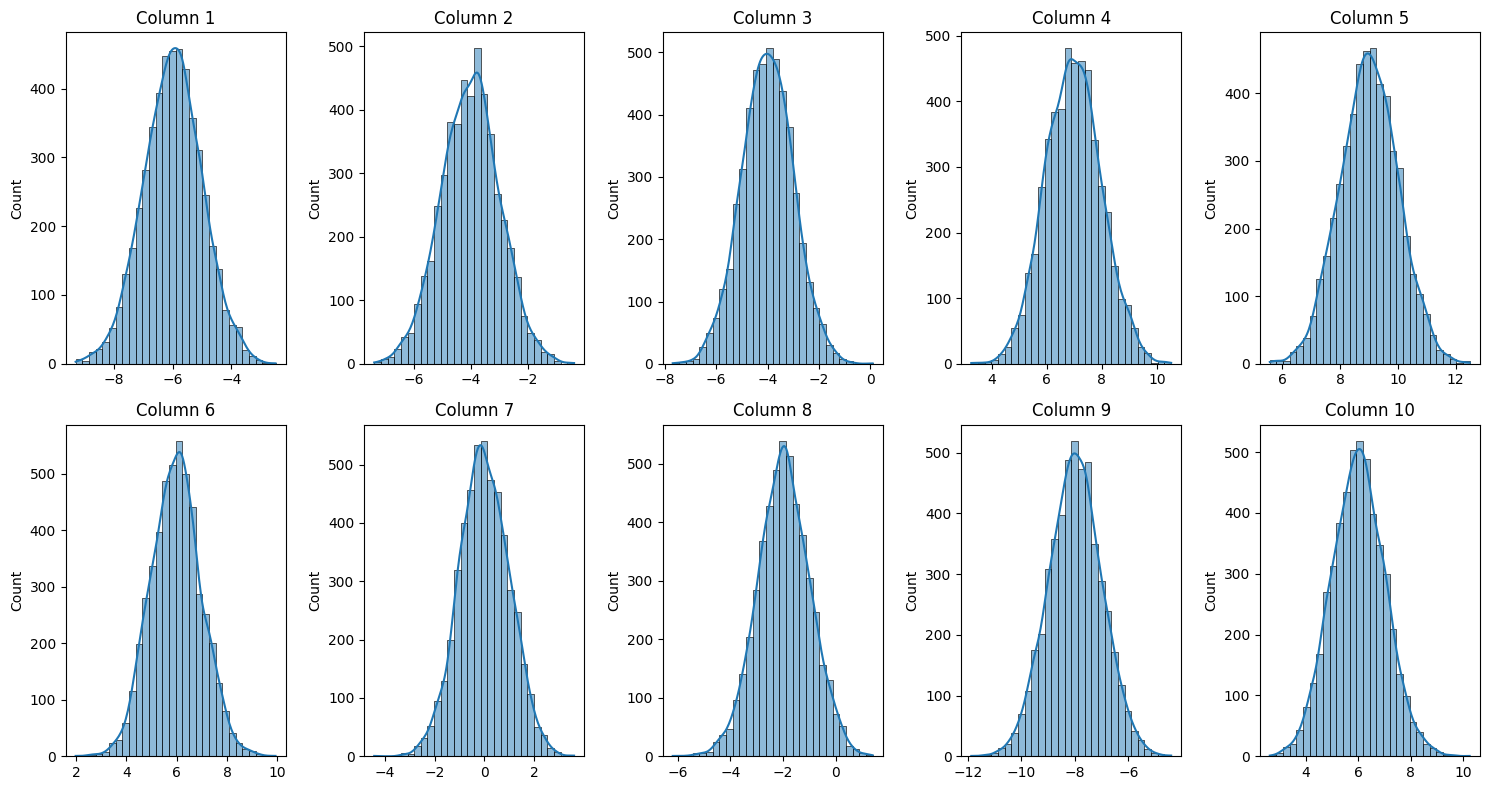

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
data_size = 5000
np.random.seed(64)
# Generate a random integer array 'a' with shape (10, 1)
a = np.random.randint(-10, 10, size=(10, 1))

# Flatten 'a' to create the mean vector for the multivariate normal distribution
mean = a.flatten()

# Generate multivariate normal data 'b' with shape (1000, 10)
b = np.random.multivariate_normal(mean=mean, cov=np.eye(10), size=data_size)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten the 2x5 axes array for easy iteration
axes = axes.flatten()

# Loop through each column of 'b' and plot its histogram on the corresponding subplot
for i in range(10):
    sns.histplot(b[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}')  # Set the title for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
X_train_5 = np.array(b[:3000,:], dtype=np.float32)
X_val_5 = np.array(b[3000:4000,:], dtype=np.float32)
X_test_5 = np.array(b[4000:5000,:], dtype=np.float32)
sc = StandardScaler()
sca_X_train_5 = sc.fit_transform(X_train_5)
sca_X_val_5 = sc.fit_transform(X_val_5)
sca_X_test_5 = sc.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=batch_size, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=batch_size, shuffle=True)
sca_test_loader_5 = DataLoader(sca_X_test_5, batch_size=batch_size, shuffle=True)

In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
model = Model(device, beta_1, beta_T, T, X_train_5.shape[1])
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
process = DiffusionProcess(beta_1, beta_T, T, model, device, X_train_5.shape[1])
traincon_ddpm(model,optim,500,sca_traindata_loader_5,sca_valdata_loader_5,100)

epoch: 0, Train Loss: 0.9594, Val Loss: 0.9183
epoch: 0, find new best loss: Train Loss: 0.9183
----------
epoch: 1, find new best loss: Train Loss: 0.9007
----------
epoch: 2, find new best loss: Train Loss: 0.8989
----------
epoch: 3, find new best loss: Train Loss: 0.8813
----------
epoch: 5, find new best loss: Train Loss: 0.8677
----------
epoch: 13, find new best loss: Train Loss: 0.8667
----------
epoch: 17, find new best loss: Train Loss: 0.8606
----------
epoch: 20, Train Loss: 0.8724, Val Loss: 0.9166
epoch: 32, find new best loss: Train Loss: 0.8606
----------
epoch: 40, Train Loss: 0.8814, Val Loss: 0.9002
epoch: 46, find new best loss: Train Loss: 0.8537
----------
epoch: 48, find new best loss: Train Loss: 0.8433
----------
epoch: 60, Train Loss: 0.8582, Val Loss: 0.8320
epoch: 60, find new best loss: Train Loss: 0.8320
----------
epoch: 80, Train Loss: 0.8707, Val Loss: 0.8765
epoch: 100, Train Loss: 0.8575, Val Loss: 0.8934
epoch: 120, Train Loss: 0.8596, Val Loss: 0.87

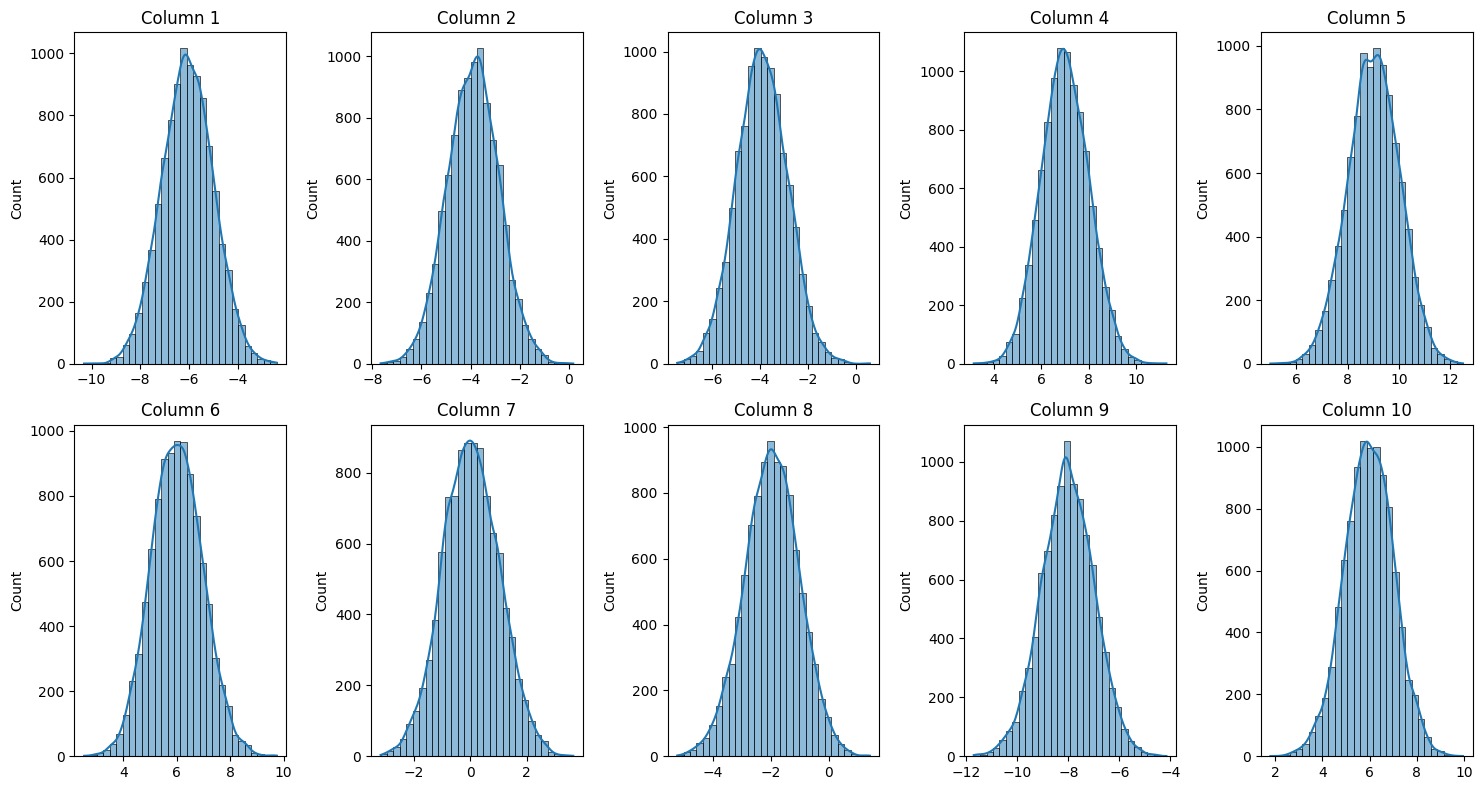

In [38]:
sampling_number = 10000
only_final = True
sample = process.sampling(sampling_number, only_final)
sample =sc.inverse_transform(sample.cpu().detach().numpy())
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(10):
    sns.histplot(sample[:, i], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Column {i+1}') 


plt.tight_layout()

# Show the plot
plt.show()
